In [1]:
import networkx as nx
import dynetx as dn

from tqdm import tqdm_notebook
import pickle
import glob
import itertools
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

In [3]:
from warnings import filterwarnings

In [4]:
pd.set_option('display.max_columns', 55)
filterwarnings('ignore')

In [5]:
def read_pickled_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
    return obj

## Tests

### dynetx

[dynetx](https://dynetx.readthedocs.io/en/latest/reference/classes/dynetx.html) library
- inter_event_time_distribution(): ??
- dynamic_G.degree(t=t): distribution of node degrees at t=t
- edge_contribution(i, n): i-n edge persistence data
- dynamic_G.adj\[i\]\[n\] - concrete t at which edge exists between i-n nodes
- dynamic_G.interactions(t=t) - edges existing at t=t

In [58]:
data_list = read_pickled_object('MDTopAnalysis_glucmdc_620K.nxg') # MDTopAnalysis_benzac02mdc MDTopAnalysis_glucmdc MDTopAnalysis_water_md_full

In [59]:
len(data_list)

251

In [60]:
G_list = [data['G'] for data in data_list]

# if there is a change in the course of MD run
G_list_1st_part = G_list[:100]
G_list_2nd_part = G_list[150:]

In [61]:
g = G_list[5]
simple_g = nx.Graph(g)

In [62]:
dynamic_G = dn.DynGraph()
all_edges = []

for i, snapshot_G in enumerate(G_list):
    snapshot_edges = list(snapshot_G.edges(keys=True))
    dynamic_G.add_interactions_from(snapshot_edges, t=i)
    all_edges.extend([(*sorted(e[:2]), e[2]) for e in snapshot_edges])
    # !!! ok for large P1 cells, won't work for small cell with symmetry !!! #

In [87]:
res = []

for g in G_list:
    frame_res = []
    sg = nx.Graph(g)
    for cc in nx.connected_components(sg):
        subg = sg.subgraph(cc)
        prop = nx.kemen(subg)
        # prop = nx.communicability(nx.Graph(subg))
        # frame_res.append(prop)
        frame_res.append(np.mean(list(prop.values())))

    res.append(np.mean(frame_res))

<AxesSubplot:>

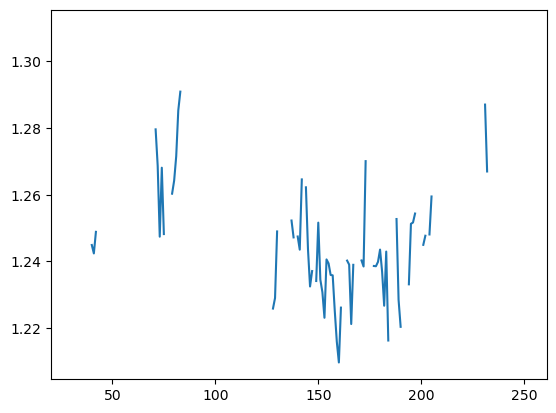

In [88]:
pd.Series(res).plot()

In [77]:
from collections import Counter, defaultdict

In [78]:
counter = Counter(all_edges)

In [124]:
counter.most_common(n=10)

[((16, 19, (0, 0, 0)), 51),
 ((6, 109, (0, 0, 0)), 51),
 ((112, 115, (0, 0, 0)), 51),
 ((120, 139, (0, 0, 0)), 51),
 ((136, 139, (0, 0, 0)), 51),
 ((172, 175, (0, 0, 0)), 51),
 ((0, 3, (0, 0, 0)), 50),
 ((13, 110, (1, 0, 1)), 50),
 ((14, 113, (0, 0, 0)), 50),
 ((14, 117, (0, 0, 0)), 50)]

In [81]:
edges_locations = defaultdict(list)

for edge, count in counter.items():
    n1, n2, t = edge
    n1 = n1 if n1 < n2 else n2
    n2 = n2 if n2 > n1 else n1
    # if 3 in (n1, n2):
    #     print(n1, n2, t, count)
    edges_locations[(n1, n2)].append((edge, count))

In [115]:
selected_edges = []
skipped_edges = []

for nodes_pair, edges_data in edges_locations.items():

    edge_persistence = dynamic_G.edge_contribution(*nodes_pair)

    if edge_persistence < 0.05:
        skipped_edges.append((*edges_data, edge_persistence))
        continue

    if len(edges_data) > 1:
        most_common_edge = sorted(edges_data, key=lambda x: x[1])[-1]
        selected_edges.append([*most_common_edge[0], edge_persistence])
    else:
        selected_edges.append([*edges_data[0][0], edge_persistence])

In [116]:
len(skipped_edges)

294

In [15]:
dynamic_G.coverage()

0.9975490196078431

In [16]:
dynamic_G.density(), dn.density(dynamic_G, t=11),\
dn.density(dynamic_G, t=5), dn.density(dynamic_G, t=0),\
dn.density(dynamic_G)

(0.012371105438573214, 0, 0, 0, 0.048040201005025124)

numbers for glu at 420K < glu at 620K

In [81]:
dynamic_G.interactions_per_snapshots(t=0),\
dynamic_G.interactions_per_snapshots(t=10),\
dynamic_G.interactions_per_snapshots(t=50),\
dynamic_G.interactions_per_snapshots(t=100),\
dynamic_G.interactions_per_snapshots(t=149)

(208.0, 366.0, 388.0, 0, 0)

In [17]:
dynamic_G.uniformity()

0.9951157316401466

In [21]:
g.edges(keys=True)

MultiEdgeView([(0, 3, (0, 0, 0)), (0, 19, (0, 0, 0)), (19, 16, (0, 0, 0)), (1, 17, (0, 0, 0)), (1, 118, (1, 0, 0)), (1, 102, (1, 0, 0)), (17, 118, (1, 0, 0)), (17, 114, (1, 0, 0)), (102, 5, (1, 0, 0)), (2, 105, (0, 0, 0)), (2, 101, (0, 0, 0)), (105, 6, (0, 0, 0)), (101, 18, (0, 0, 0)), (101, 125, (0, 0, 0)), (4, 7, (0, 0, 0)), (4, 84, (0, 0, 0)), (7, 8, (0, 0, 1)), (84, 83, (0, 0, 0)), (84, 87, (0, 0, 0)), (5, 106, (1, 0, 0)), (106, 9, (1, 0, 0)), (6, 109, (0, 0, 0)), (109, 10, (0, 0, 0)), (109, 129, (0, 0, 0)), (109, 189, (0, 0, 0)), (8, 11, (0, 0, 0)), (11, 12, (0, 0, 0)), (9, 110, (1, 0, 0)), (9, 127, (0, 0, 0)), (110, 13, (1, 0, 1)), (127, 29, (0, 0, 0)), (127, 124, (0, 0, 0)), (127, 128, (0, 0, 1)), (10, 113, (0, 0, 1)), (113, 14, (0, 0, 0)), (113, 31, (0, 0, 0)), (12, 15, (0, 0, 0)), (15, 16, (0, 0, 0)), (13, 114, (1, 0, 0)), (13, 131, (0, 0, 0)), (131, 128, (0, 0, 0)), (131, 132, (0, 0, 0)), (14, 117, (0, 0, 0)), (117, 18, (0, 0, 0)), (20, 39, (0, 0, 0)), (39, 36, (0, 0, 0)), (2

In [34]:
dynamic_G.edges(keys=False)

In [63]:
res = []

for e in dynamic_G.edges:
    contribution = dynamic_G.edge_contribution(*e)
    if contribution > 1.0:
        print(e, contribution)
    res.append((e, contribution))

<AxesSubplot:>

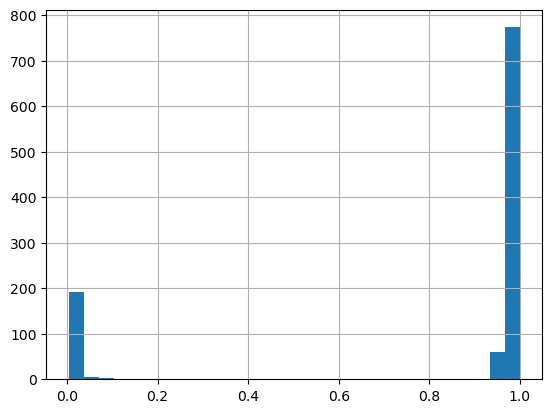

In [64]:
pd.DataFrame(res, columns=['edge', 'p']).sort_values(by='p', ascending=False)['p'].hist(bins=30) # 295K

<AxesSubplot:>

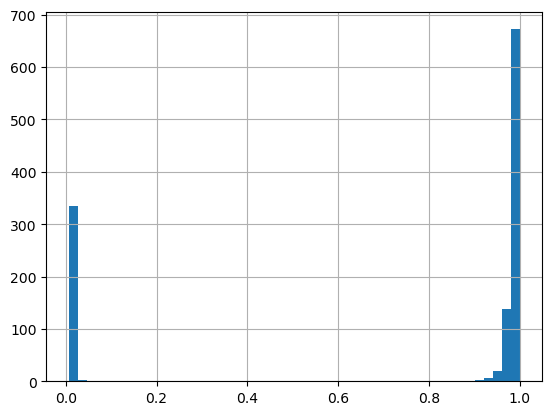

In [10]:
pd.DataFrame(res, columns=['edge', 'p']).sort_values(by='p', ascending=False)['p'].hist(bins=50) # 420K

<AxesSubplot:>

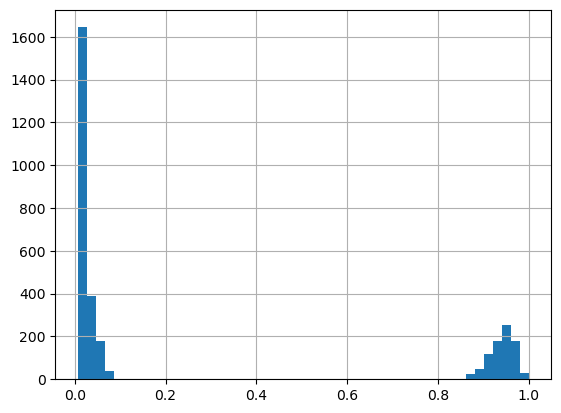

In [17]:
pd.DataFrame(res, columns=['edge', 'p']).sort_values(by='p', ascending=False)['p'].hist(bins=50) # 620K

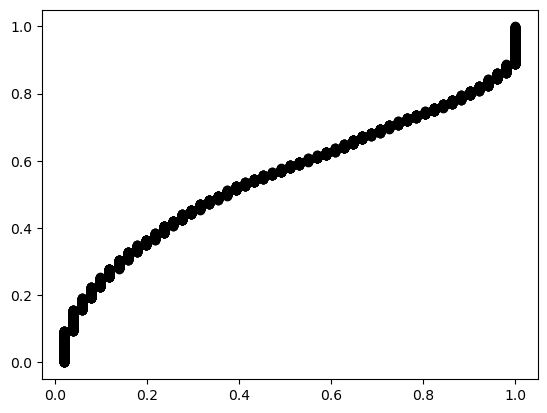

In [185]:
df = pd.DataFrame(res, columns=['edge', 'p'])
data_sorted = np.sort(df['p'].values)

# _ = plt.hist(data_sorted, bins=100, density=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k')

data_sorted = np.sort(data_sorted)
y = np.arange(len(data_sorted)) / len(data_sorted)
plt.plot(data_sorted, y, 'ok-')

# plt.legend()

In [53]:
n1, n2 = 0, 42
n3, n4 = 0, 42

In [54]:
dynamic_G.adj[n1][n2]

KeyError: 0

In [39]:
dynamic_G.edge_contribution(n1, n2), dynamic_G.edge_contribution(n3, n4)

(0.08191808191808192, 0.08191808191808192)

In [40]:
dynamic_G.inter_event_time_distribution(n1, n2), dynamic_G.inter_event_time_distribution(n3, n4)

({25: 1,
  1: 14,
  2: 7,
  12: 2,
  9: 2,
  7: 3,
  16: 2,
  14: 3,
  30: 1,
  22: 1,
  4: 3,
  5: 3,
  3: 2,
  17: 3,
  36: 1,
  10: 3,
  6: 3,
  53: 2,
  31: 1,
  18: 3,
  8: 2,
  13: 3,
  27: 1,
  11: 1,
  26: 1,
  35: 1,
  45: 1,
  41: 1,
  24: 1,
  44: 1,
  50: 1,
  19: 1},
 {25: 1,
  1: 14,
  2: 7,
  12: 2,
  9: 2,
  7: 3,
  16: 2,
  14: 3,
  30: 1,
  22: 1,
  4: 3,
  5: 3,
  3: 2,
  17: 3,
  36: 1,
  10: 3,
  6: 3,
  53: 2,
  31: 1,
  18: 3,
  8: 2,
  13: 3,
  27: 1,
  11: 1,
  26: 1,
  35: 1,
  45: 1,
  41: 1,
  24: 1,
  44: 1,
  50: 1,
  19: 1})

In [65]:
len(dynamic_G), len(G_list), len(dynamic_G.nodes())

(168, 251, 168)

In [66]:
dt_distribution = []
max_t = len(G_list)

for i in range(g.number_of_nodes()):
    for n in dynamic_G.adj[i]:
        dt = dynamic_G.inter_event_time_distribution(i, n)
        if len(dt) == 0: #  or max_t in dt.keys()
            continue # dt = {0: 1}
        # if max(dt.keys()) > 149:
        #     print(i, n, dt)
        dt_distribution.extend([(k, )*v for k, v in dt.items() if v != max_t])

In [67]:
dt_distribution = tuple(itertools.chain(*dt_distribution))

In [ ]:
dt_distribution

In [68]:
max(dt_distribution)

250

In [69]:
dt_distribution = pd.Series(dt_distribution).value_counts()

Text(0, 0.5, 'count')

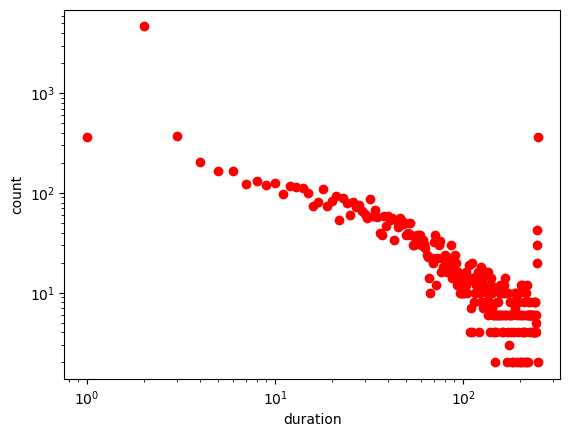

In [70]:
# x, y = dt_distribution_s_HD.index, dt_distribution_s_HD.values
# plt.plot(x, y, 'or')

# x, y = dt_distribution_s_LD.index, dt_distribution_s_LD.values
# plt.plot(x, y, 'ok')

x, y = dt_distribution.index, dt_distribution.values
plt.plot(x, y, 'or')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('duration')
plt.ylabel('count')

In [74]:
i = 0
for n in dynamic_G.adj[i]:
    c = dynamic_G.edge_contribution(i, n)
    dt = dynamic_G.inter_event_time_distribution(i, n)
    print(dynamic_G.adj[i][n])
    print('edge', f'{i}-{n} persistence: {c} |', 'dt:', dt, '\n')

{'t': [[0, 250]]}
edge 0-58 persistence: 1.0 | dt: {250: 1} 

{'t': [[0, 250]]}
edge 0-141 persistence: 1.0 | dt: {250: 1} 

{'t': [[0, 33], [35, 89], [91, 123], [125, 250]]}
edge 0-82 persistence: 0.9880478087649402 | dt: {33: 1, 2: 3, 54: 1, 32: 1, 125: 1} 

{'t': [[0, 8], [10, 64], [66, 76], [79, 114], [116, 127], [129, 157], [159, 203], [205, 215], [217, 250]]}
edge 0-55 persistence: 0.9641434262948207 | dt: {8: 1, 2: 7, 54: 1, 10: 2, 3: 1, 35: 1, 11: 1, 28: 1, 44: 1, 33: 1} 

{'t': [[0, 28], [30, 39], [42, 167], [169, 250]]}
edge 0-111 persistence: 0.9840637450199203 | dt: {28: 1, 2: 2, 9: 1, 3: 1, 125: 1, 81: 1} 

{'t': [[0, 1], [3, 250]]}
edge 0-86 persistence: 0.9960159362549801 | dt: {1: 1, 2: 1, 247: 1} 

{'t': [[0, 1], [3, 250]]}
edge 0-87 persistence: 0.9960159362549801 | dt: {1: 1, 2: 1, 247: 1} 

{'t': [[0, 89], [91, 250]]}
edge 0-110 persistence: 0.9960159362549801 | dt: {89: 1, 2: 1, 159: 1} 

{'t': [[0, 108], [110, 250]]}
edge 0-29 persistence: 0.9960159362549801 | dt:

In [86]:
pd.Series(dynamic_G.degree(t=250)).value_counts()

10    145
9      20
11      2
8       1
Name: count, dtype: int64

In [ ]:
dynamic_G.interactions(t=5)

# Analysis

In [6]:
class TemporalNetworkAnalysis:

    def __init__(self, data_list: list):

        G_list = [data['G'] for data in data_list]
        nodes_data_list = [pd.DataFrame(data['nodes_data']) for data in data_list]

        self.dG, self._all_edges = self._create_dynamic_graph(G_list)
        self._create_weighted_static_graph(G_list[0])
        self._collect_nodes_list_data(nodes_data_list)

    def _create_dynamic_graph(self, G_list):
        """
        Create dynamic graph object from a list of snapshot graphs
        as well as collecting all edges ever encountered in the snapshots
        """
        all_edges = []
        dynamic_G = dn.DynGraph()

        for i, snapshot_G in enumerate(G_list):
            snapshot_edges = list(snapshot_G.edges(keys=True))
            dynamic_G.add_interactions_from(snapshot_edges, t=i)
            all_edges.extend([(*sorted(e[:2]), e[2]) for e in snapshot_edges])

        return dynamic_G, all_edges

    def _create_weighted_static_graph(self, G0):
        """
        Create static representation of the dynamic graph as a weighted graph
        """
        # G0 - first graph in a list used for weighted static graph construction -
        # stores node coordinates for visualisation
        wsG = G0.copy()
        wsG.remove_edges_from(list(wsG.edges()))
        self.wsG = wsG

        # at first make a list with all edges ever encountered along the trajectory
        # and group edges between the same nodes pair but with different translations
        counter = Counter(self._all_edges)
        edges_locations = defaultdict(list)

        for edge, count in counter.items():
            n1, n2, t = edge
            n1 = n1 if n1 < n2 else n2
            n2 = n2 if n2 > n1 else n1
            edges_locations[(n1, n2)].append((edge, count))


        # now if the edge between a pair of nodes occured with different translations
        # select the translation which appeared most frequently
        selected_edges = []
        all_edges = []

        for nodes_pair, edges_data in edges_locations.items():

            edge_persistence = self.dG.edge_contribution(*nodes_pair)

            if len(edges_data) > 1:
                most_common_edge = sorted(edges_data, key=lambda x: x[1])[-1]
                selected_edges.append([*most_common_edge[0], edge_persistence])
                all_edges.extend([[*ed, edge_persistence] for ed in edges_data])
            else:
                selected_edges.append([*edges_data[0][0], edge_persistence])
                all_edges.append([*edges_data[0][0], edge_persistence])

        self._all_edges = all_edges
        self._edge_persistence_list = sorted(selected_edges, key=lambda x: x[-1], reverse=True)

        for n1, n2, translation, persistence in self._edge_persistence_list:
            self.wsG.add_edge(n1, n2, key=translation, weight=persistence)

    def _collect_nodes_list_data(self, nodes_list):
        """
        Combine the node VDP characteristics from each frame into a single dataframe
        """
        df = pd.concat(nodes_list, axis=1).T
        df = df.astype({
            'frame': 'int32',
            'neighbours_SA_CV': 'float',
            'N_direct_neighbours': 'int8',
            'N_indirect_neighbours': 'int8',
            'N_neighbours': 'int8',
            'neighbours_indices': 'object',
            'MCN': 'int8',
            })

        self.node_characteristics = df

        # equal number of molecules should be in each frame throughout trajectory
        if len(df.groupby('frame')['MCN'].count().value_counts()) > 1:
            print('!!!! WARNING: number of molecules in a frame throughout trajectory ARE NOT EQUAL !!!!')
            print('N_molecules: N_frames with N_molecules')
            print('\n'.join(
                [f"{k}: {v}" for k, v in df.groupby('frame')['MCN'].count().value_counts().to_dict().items()]
            )
                 )

    def show_edge_contribution_info(self, plot_edge_weigts=True, return_persistence_df=False, title=''):
        """
        Show data on the edge persistence
        """
        df = pd.DataFrame(
            self._edge_persistence_list,
            columns=['node1', 'node2', 'translation', 'persistence']
        ).sort_values(by='persistence', ascending=False)

        if plot_edge_weigts:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
            fig.suptitle(title)
            df['persistence'].hist(bins=40, density=True, label='hist', ax=ax1)
            df['persistence'].plot.kde(bw_method=0.035, lw=2.0, color='navy', label='kde', ax=ax1)
            ax1.set_title('Edge persistence distribution')
            ax1.set_xlabel('persistence')
            ax1.set_xlim(-0.01, 1.01)
            data_sorted = np.sort(df['persistence'].values)
            y = np.arange(len(data_sorted)) / len(data_sorted)
            ax2.set_title('Edge persistence CDF')
            ax2.plot(data_sorted, y, 'k-', lw=2.5)
            ax2.set_xlabel('persistence')
            ax1.legend()
            plt.show()

        if return_persistence_df:
            return df

    def get_filtered_weighted_static_graph(self, edge_weight_threshold=0.9):
        """
        Return graph with edges filtered to have weight >= edge_weight_threshold.
        Nodes are taken from the first snapshot graph in the G_list
        """

        filtered_wsG = self.wsG.copy()
        filtered_wsG.remove_edges_from(list(filtered_wsG.edges()))

        for edge in self.wsG.edges(keys=True, data=True):
            n1, n2, translation, data = edge
            if data['weight'] >= edge_weight_threshold:
                filtered_wsG.add_edge(n1, n2, key=translation, weight=data['weight'])

        return filtered_wsG

In [7]:
def plot_node_characteristics(df, rolling_mean_periods=15):

    N_FRAMES = df['frame'].unique()

    df_vdp_mean_std = df.groupby('frame')[
        ['neighbours_SA_CV', 'N_direct_neighbours', 'N_indirect_neighbours', 'N_neighbours', 'MCN']
    ].agg(['mean', 'std'])

    for descriptor in ['neighbours_SA_CV', 'N_direct_neighbours', 'N_indirect_neighbours', 'N_neighbours', 'MCN']:
        plt.figure(figsize=(9, 4))
        plt.title(descriptor)
        plt.grid(visible=True, axis='y', color='k', linestyle='--', linewidth=0.5)
        plt.plot(df_vdp_mean_std[(descriptor, 'mean')], alpha=0.8, label='mean')
        plt.plot(df_vdp_mean_std[(descriptor, 'mean')].rolling(rolling_mean_periods).mean(),
                 color='k', alpha=1.0, label=f'moving average ({rolling_mean_periods})')
        plt.fill_between(
            N_FRAMES,
            df_vdp_mean_std[(descriptor, 'mean')] - df_vdp_mean_std[(descriptor, 'std')],
            df_vdp_mean_std[(descriptor, 'mean')] + df_vdp_mean_std[(descriptor, 'std')],
            alpha=0.25,
            label='+/-std'
        )
        plt.xlim(N_FRAMES.min() - 5, N_FRAMES.max() + 5)
        plt.xlabel('frame')
        plt.ylabel(descriptor)
        plt.legend()
        plt.show()

In [8]:
def calculate_neighbour_exchange_time(df_dict, share_neighbours_changed=0.5):

    total_frames = np.array(list(df_dict.keys()))
    max_frame = total_frames.max()
    atoms_per_frame = len(df_dict[total_frames[0]])

    exchange_times = {}

    for i in tqdm_notebook(total_frames[:-1]):

        frame_i = df_dict[i]
        exchange_times_for_frame_i = {}

        for atom in range(atoms_per_frame):
            initial_neighbors = frame_i[atom]
            N_initial_neighbors = len(initial_neighbors)
            for j in total_frames[total_frames > i]:
                frame_j = df_dict[j]
                current_neighbors = frame_j[atom]

                if j == max_frame:
                    exchange_times_for_frame_i[atom] = np.nan

                elif len(initial_neighbors & current_neighbors) < N_initial_neighbors * (1 - share_neighbours_changed):
                    exchange_times_for_frame_i[atom] = j - i
                    break

        if exchange_times_for_frame_i:
            exchange_times[i] = exchange_times_for_frame_i

    return exchange_times

In [9]:
def plot_neighbour_exchange_times(df_dict, exchange_shares=(0.25, 0.5, ), title=''):

    fig, ax = plt.subplots(figsize=(16, 5))
    ax2 = ax.twinx()
    ax.set_title(title)

    for share in exchange_shares:
        exchange_times = calculate_neighbour_exchange_time(df_dict, share_neighbours_changed=share)
        df_exchange_times = pd.DataFrame(exchange_times)
        df_exchange_times.median().T.plot(ax=ax, label=f"{int(share*100)}%")
        df_exchange_times.isna().sum(axis=0).plot(ax=ax2, label=f"nans ({int(share*100)}%)", ls='--', lw=0.5)

    ax.legend()
    ax.set_xlabel('start frame')
    ax.set_ylabel('median number of a frame by which neighbours are changed by X%')
    ax2.set_ylabel('nans count per frame', color='navy')
    ax.set_xlim(min(df_dict.keys()) - 5, max(df_dict.keys()) + 5)
    plt.grid(visible=True, axis='y', color='k', linestyle='--', linewidth=.5)

In [10]:
def calculate_neighbour_exchange_count(df_dict, exchange_type='delta_CN'):

    total_frames = np.array(list(df_dict.keys()))
    atoms_per_frame = len(df_dict[total_frames[0]])

    exchange_counts = {}

    for i, j in tqdm_notebook(zip(total_frames, total_frames[1:])):

        frame_i = df_dict[i]
        frame_j = df_dict[j]

        exchange_counts_for_frames_ij = {}

        for atom in range(atoms_per_frame):
            initial_neighbors = frame_i[atom]
            current_neighbors = frame_j[atom]

            if exchange_type == 'delta_CN':
                change = len(current_neighbors) - len(initial_neighbors)
            elif exchange_type == 'N_neighbours_in':
                change = len(current_neighbors - initial_neighbors)
            elif exchange_type == 'N_neighbours_out':
                change = len(initial_neighbors - current_neighbors)
            elif exchange_type == 'N_neighbours_retained':
                change = len(initial_neighbors & current_neighbors)
            else:
                change = -123456789

            exchange_counts_for_frames_ij[atom] = change

        exchange_counts[i] = exchange_counts_for_frames_ij

    return exchange_counts

In [144]:
system = 'benzac02mdc_reverse'
data_list = read_pickled_object(f'MDTopAnalysis_{system}.nxg') # water_md_full etolmdc bzammdc glucmdc benzac02mdc_reverse pntnmdc

In [145]:
tn_analysis = TemporalNetworkAnalysis(data_list)

!!!! WARNING: number of molecules in a frame throughout trajectory ARE NOT EQUAL !!!!
N_molecules: N_frames with N_molecules
432: 499
434: 2


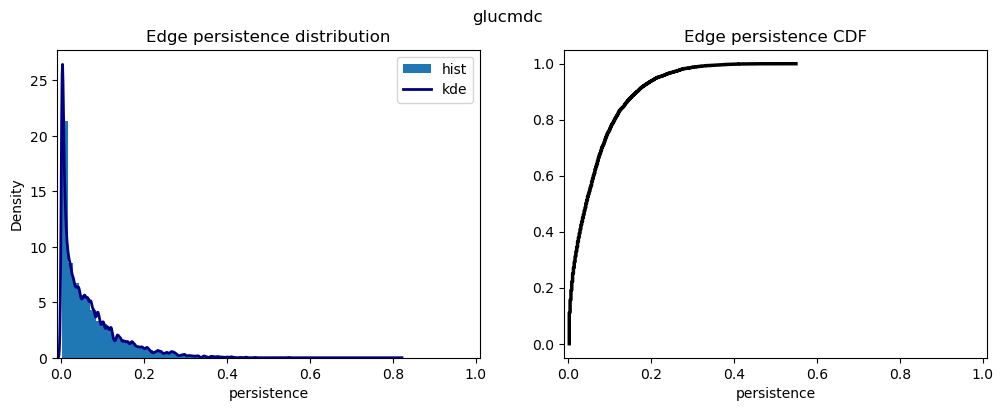

In [13]:
tn_analysis.show_edge_contribution_info(return_persistence_df=False, plot_edge_weigts=True, title=system)

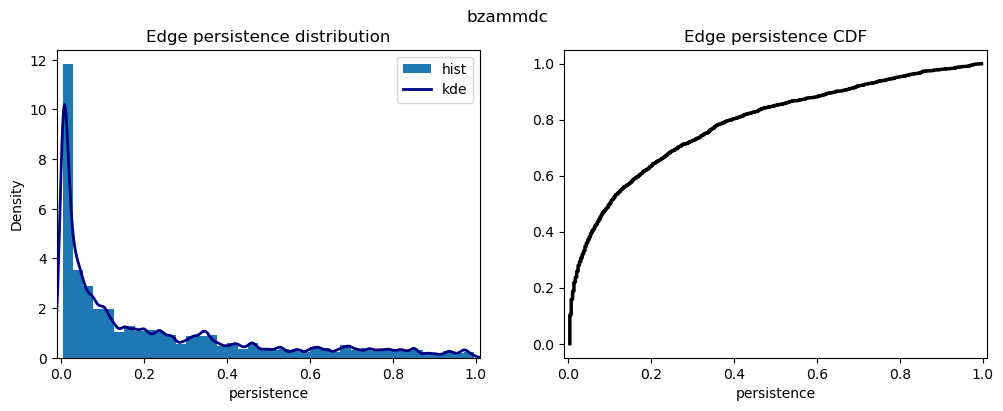

In [13]:
tn_analysis.show_edge_contribution_info(return_persistence_df=False, plot_edge_weigts=True, title=system)

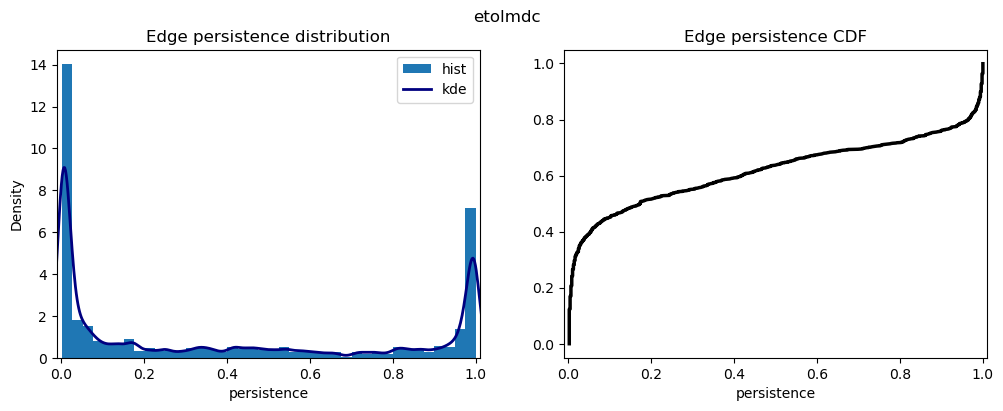

In [13]:
tn_analysis.show_edge_contribution_info(return_persistence_df=False, plot_edge_weigts=True, title=system)

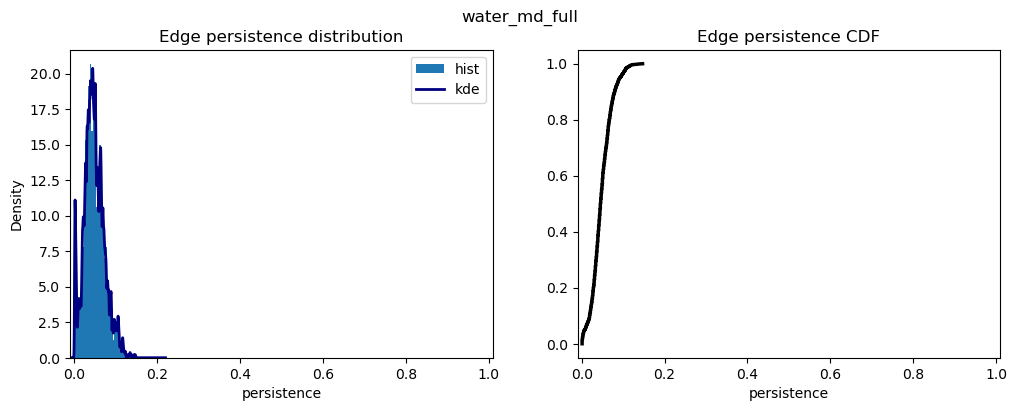

In [9]:
tn_analysis.show_edge_contribution_info(return_persistence_df=False, plot_edge_weigts=True, title=system)

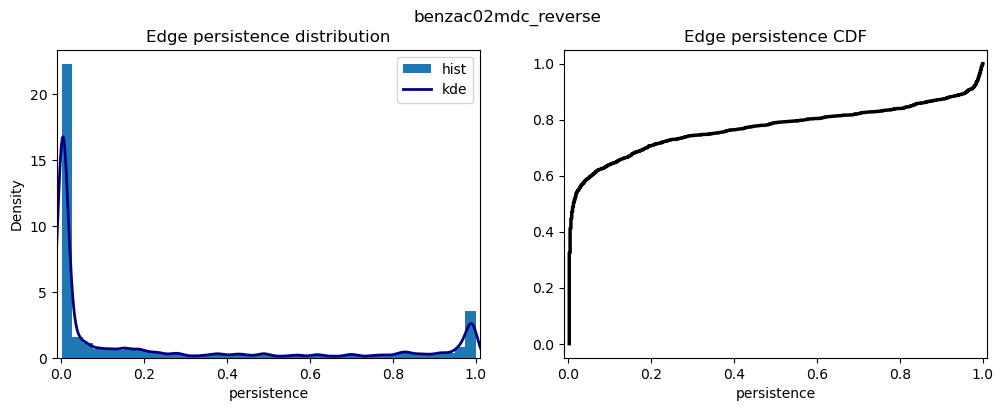

In [146]:
tn_analysis.show_edge_contribution_info(return_persistence_df=False, plot_edge_weigts=True, title=system)

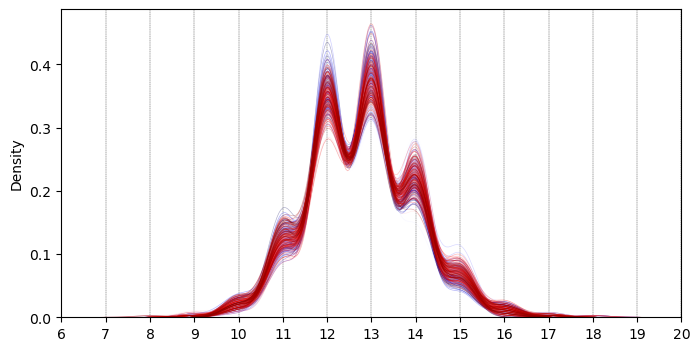

In [51]:
gb = tn_analysis.node_characteristics.groupby('frame')['N_neighbours']
palette = sns.color_palette("seismic", n_colors=len(gb))

fig, ax = plt.subplots(figsize=(8, 4))
# Plot distributions with different colors
for i, (frame, group) in enumerate(gb):
    sns.kdeplot(group.values, color=palette[i], lw=.5, alpha=0.3, ax=ax)

ax.set_xlim(6, 20)
_ = ax.set_xticks(range(6, 21))
plt.grid(visible=True, axis='x', color='k', linestyle='--', linewidth=.25)

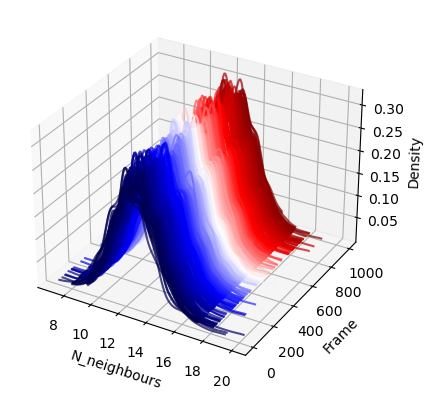

In [15]:
# Group by 'frame'
gb = tn_analysis.node_characteristics.groupby('frame')['N_neighbours']

# Generate a color palette
palette = sns.color_palette("seismic", n_colors=len(gb))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate over the groups and plot each KDE as a slice in the 3D plot
for i, (frame, group) in enumerate(gb):
    # Compute the KDE
    kde = gaussian_kde(group.values)
    x_vals = np.linspace(min(group.values), max(group.values), 100)
    y_vals = kde(x_vals)

    # Plot the KDE as a line in 3D
    ax.plot(x_vals, y_vals, zs=frame, zdir='y', color=palette[i], alpha=0.7, zorder=50-i)

# Set labels
ax.set_xlabel('N_neighbours')
ax.set_ylabel('Frame')
ax.set_zlabel('Density')

# Show plot
# ax.set_zlim(0, 4)

plt.show()

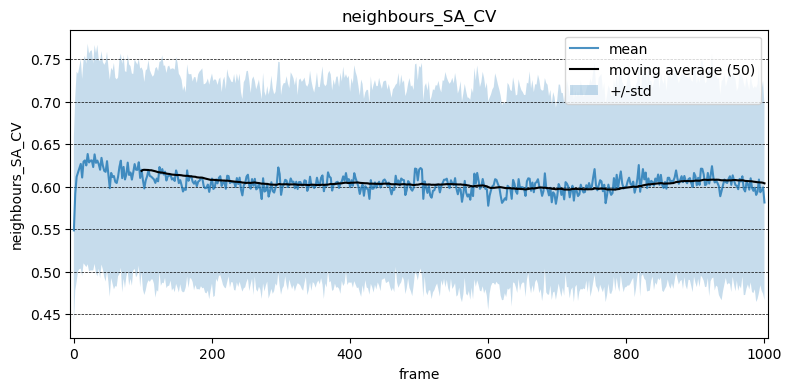

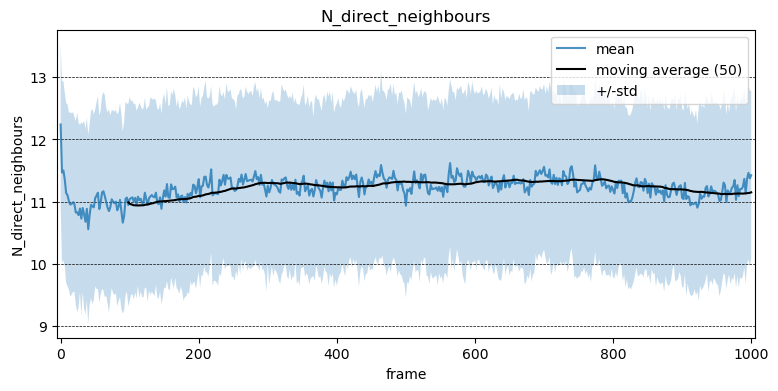

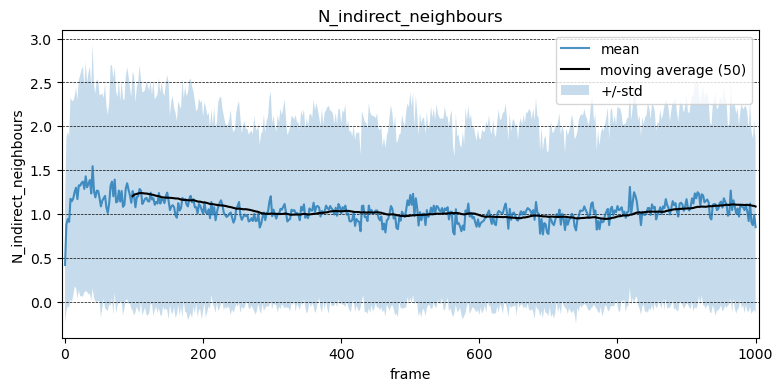

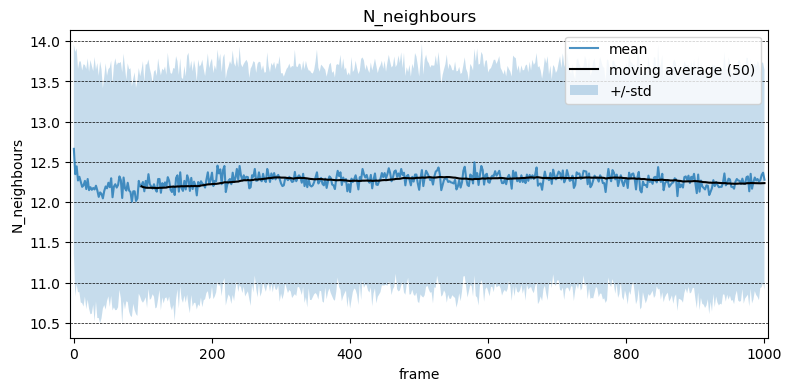

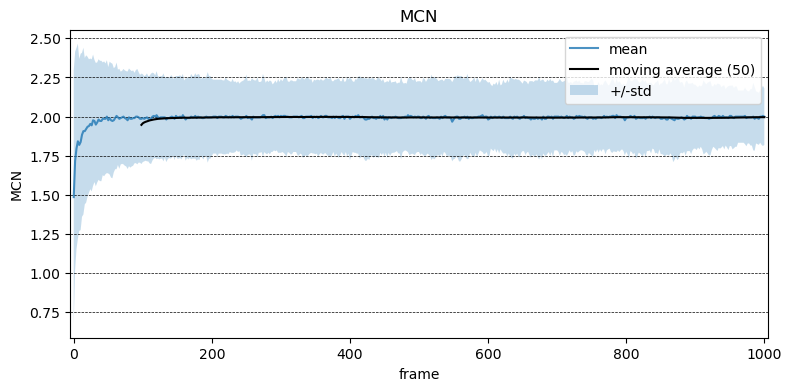

In [16]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # ethanol

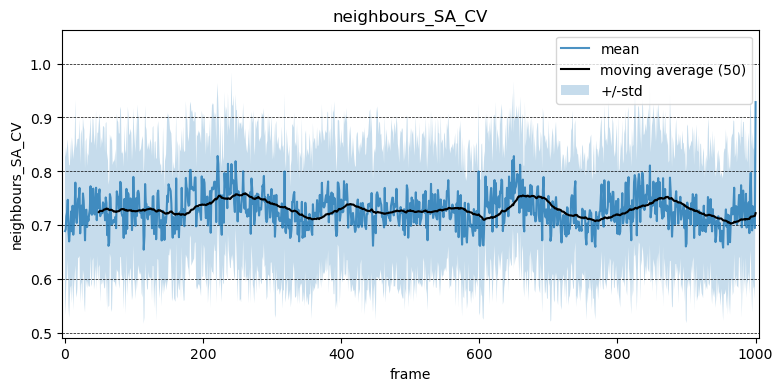

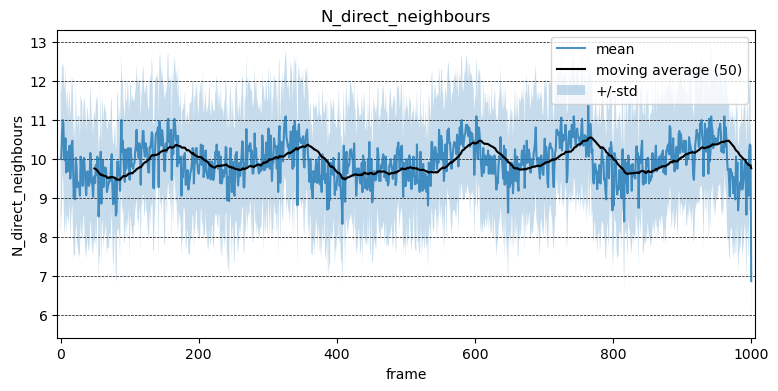

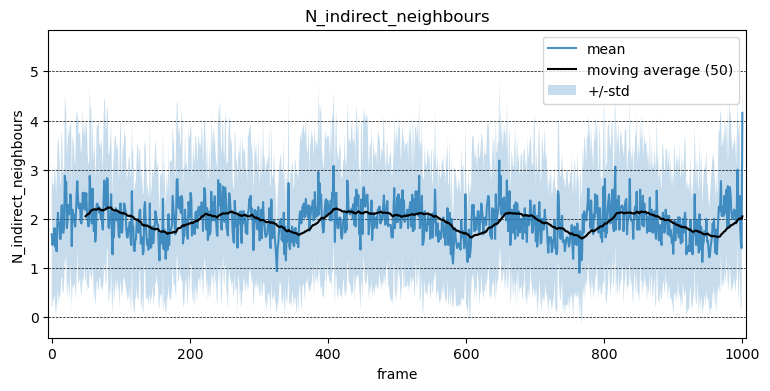

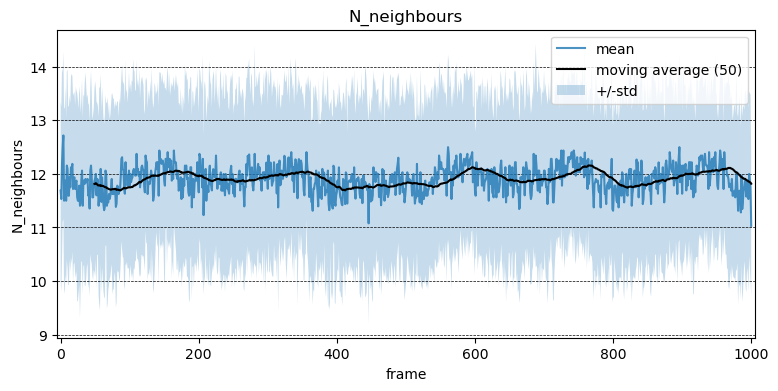

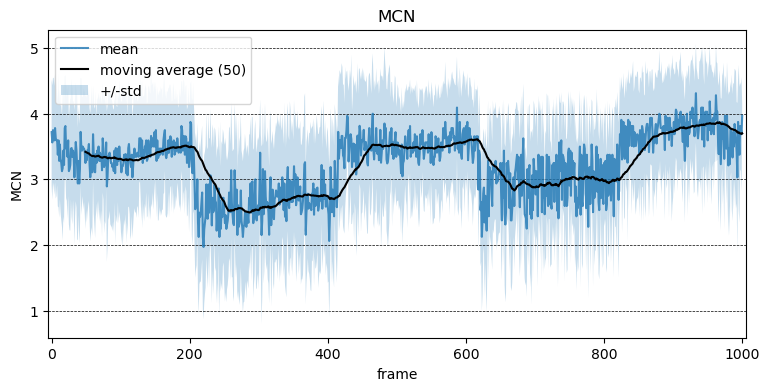

In [16]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # water

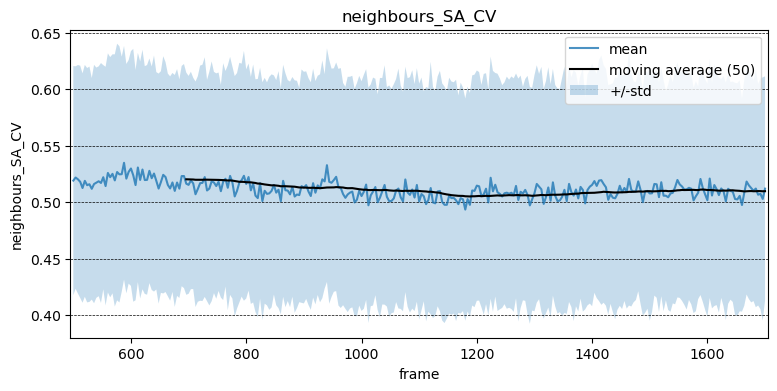

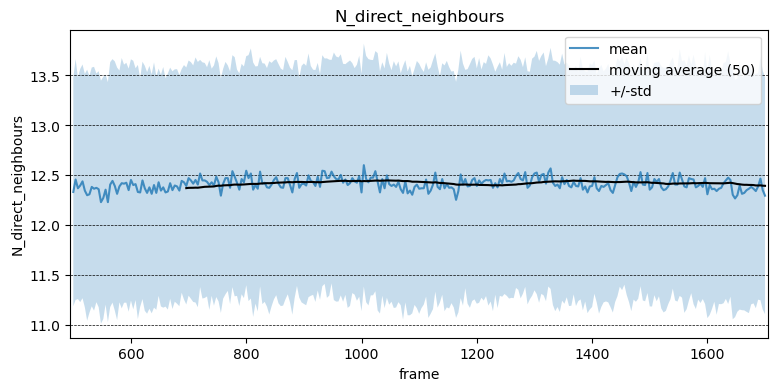

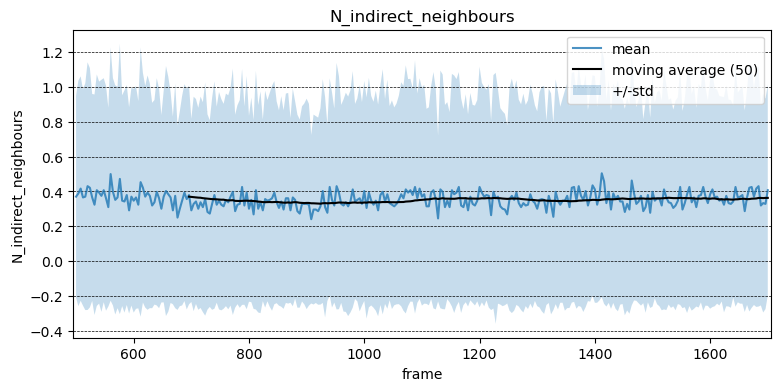

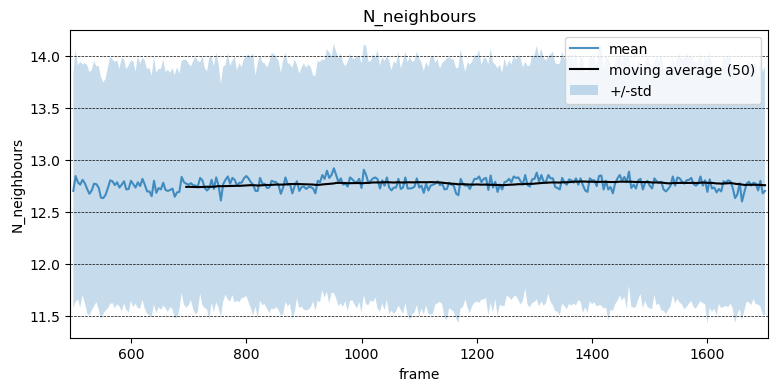

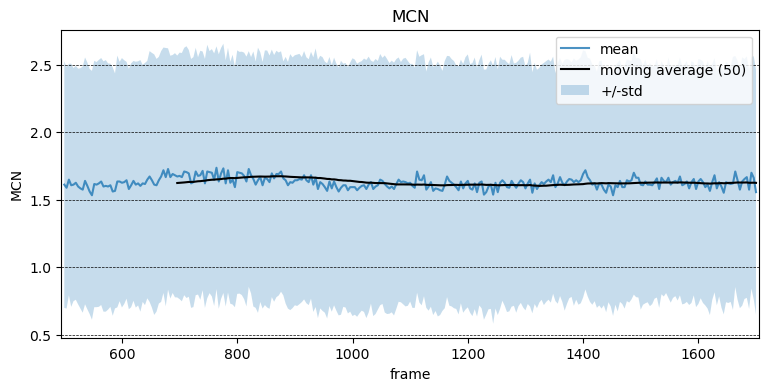

In [16]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # aniline

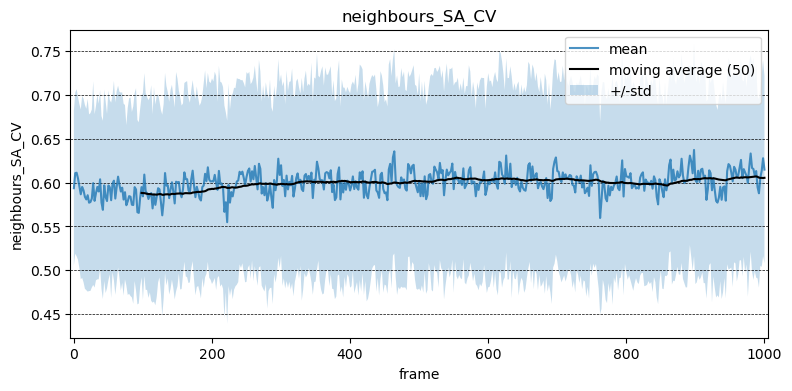

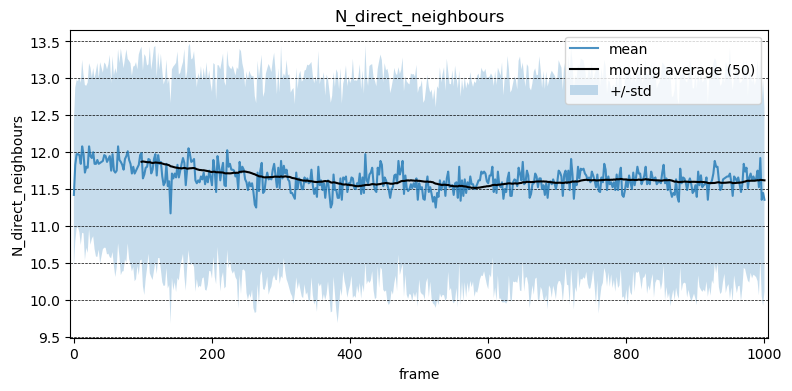

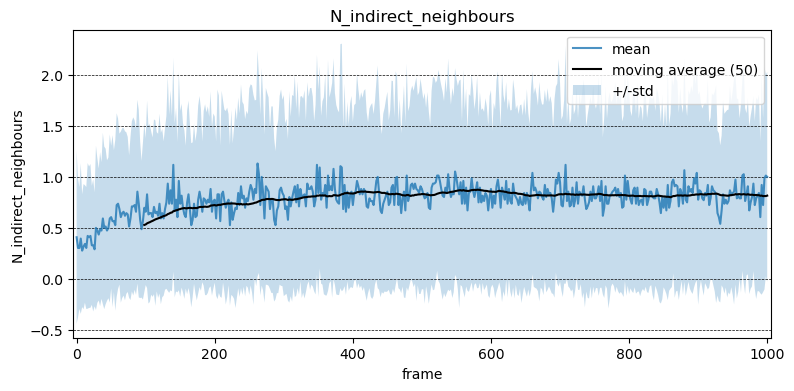

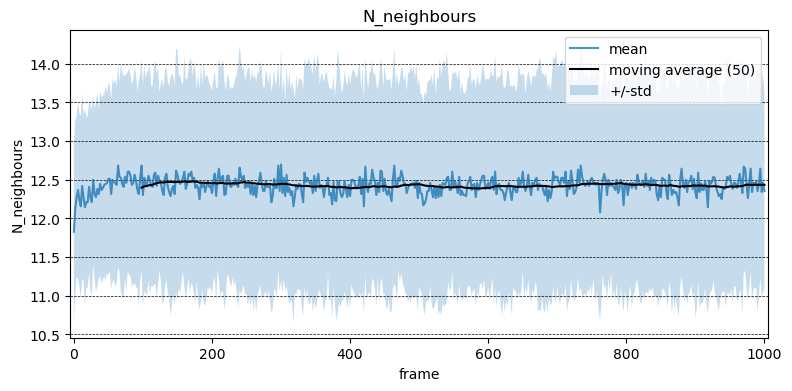

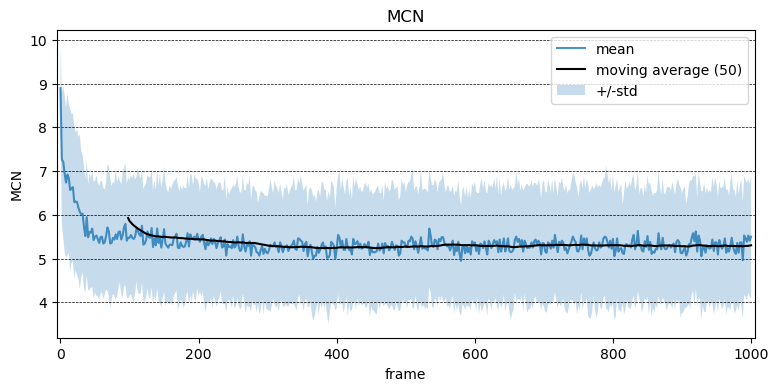

In [16]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # glucose melting

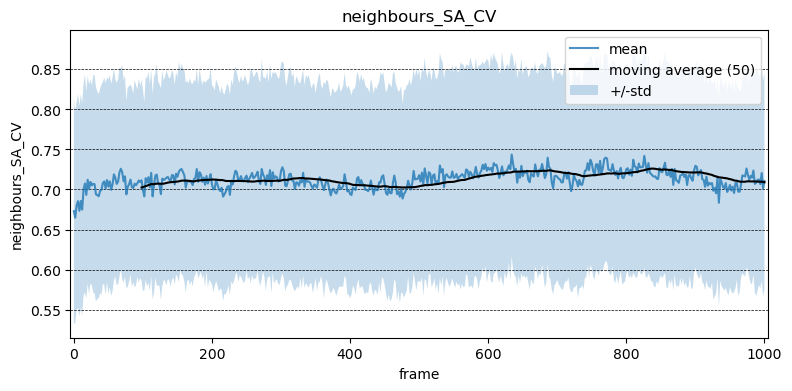

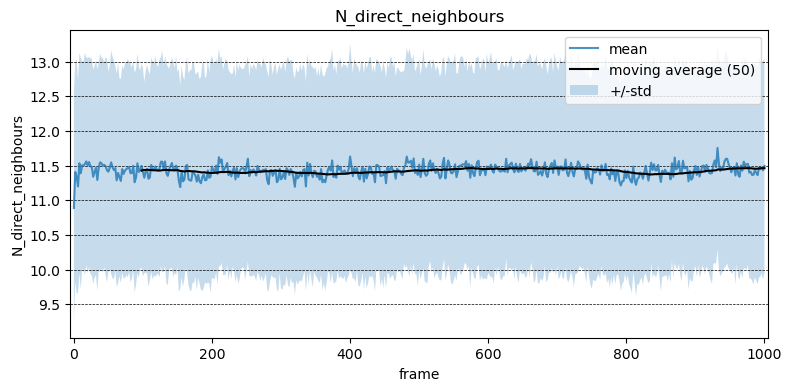

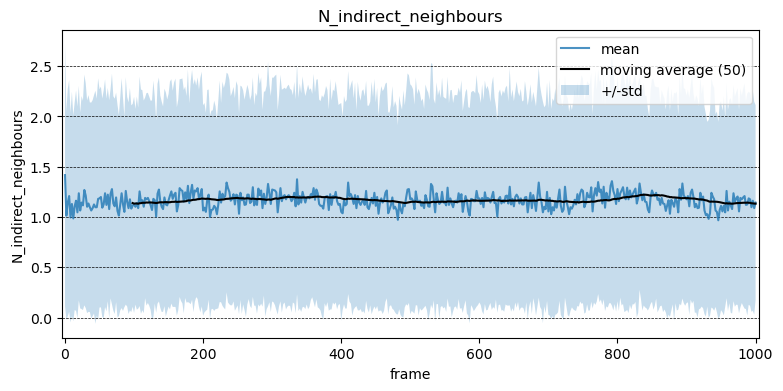

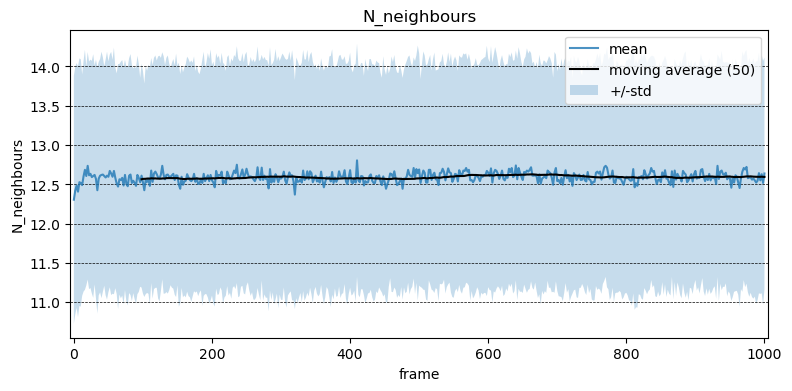

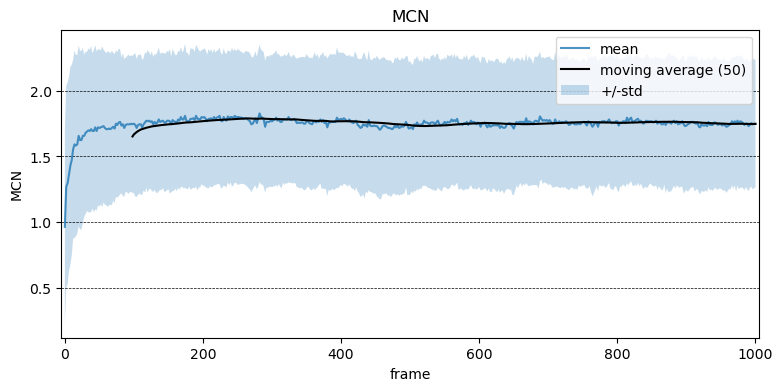

In [16]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # benzoic acid HDLD transition

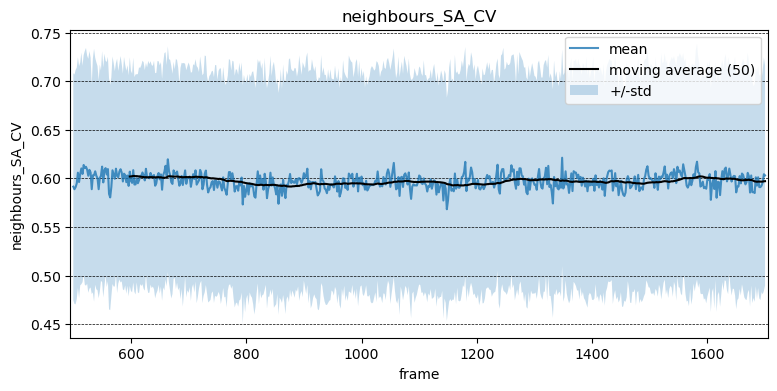

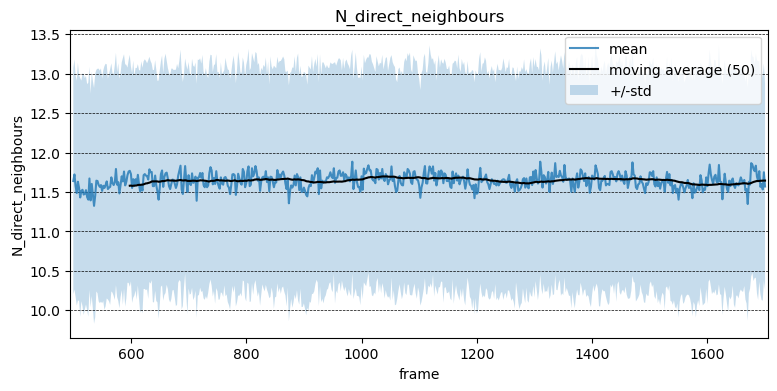

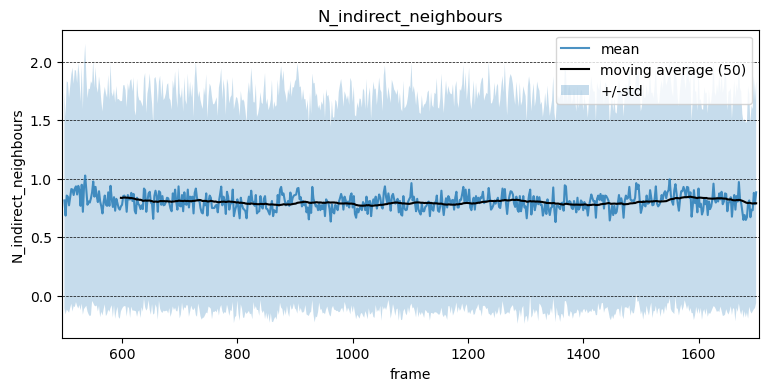

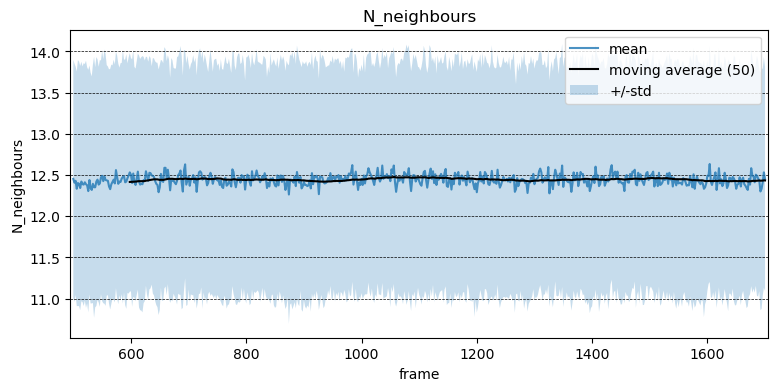

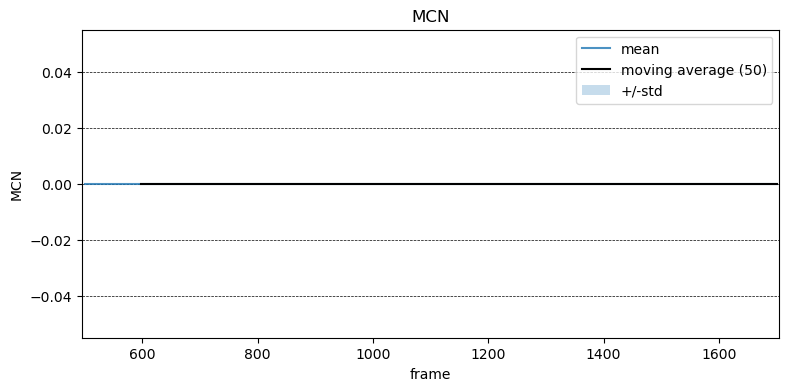

In [33]:
plot_node_characteristics(tn_analysis.node_characteristics, rolling_mean_periods=50) # pentane

In [26]:
fwsG = tn_analysis.get_filtered_weighted_static_graph(edge_weight_threshold=0.5)

In [27]:
len(fwsG.edges(data=True))

346

## Analyse neigbour exchange times

In [148]:
df = tn_analysis.node_characteristics
df['neighbours_indices'] = df['neighbours_indices'].apply(set)

In [149]:
df['frame'].nunique(), tn_analysis.node_characteristics['frame'].nunique()

(501, 501)

In [150]:
molecules_per_cell_counts = df.groupby('frame')['MCN'].count().value_counts()
molecules_per_cell_counts

MCN
432    499
434      2
Name: count, dtype: int64

In [151]:
df = df[df['frame'].isin(df.groupby('frame')['MCN'].count().loc[lambda s: s == molecules_per_cell_counts.idxmax()].index)]

In [152]:
df_dict = {frame: df[df['frame'] == frame]['neighbours_indices'].to_dict() for frame in df['frame'].unique()}

In [39]:
# Calculate and store the frame changes
exchange_times = calculate_neighbour_exchange_time(df_dict, share_neighbours_changed=0.5)

  0%|          | 0/594 [00:00<?, ?it/s]

In [41]:
df_exchange_times = pd.DataFrame(exchange_times)

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

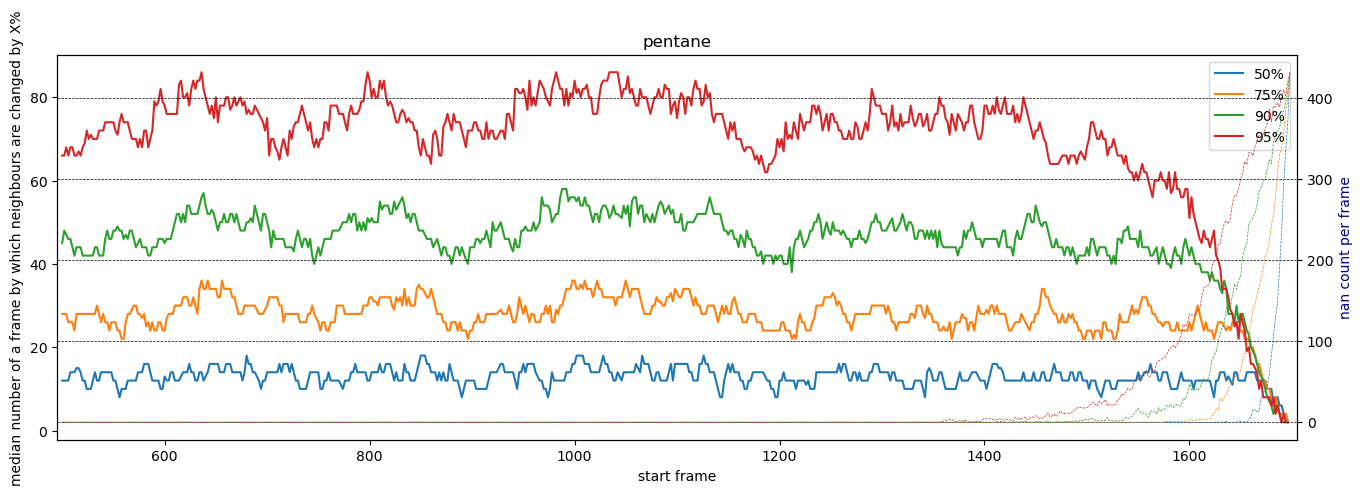

In [43]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.5, 0.75, 0.9, 0.95), title='pentane')

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

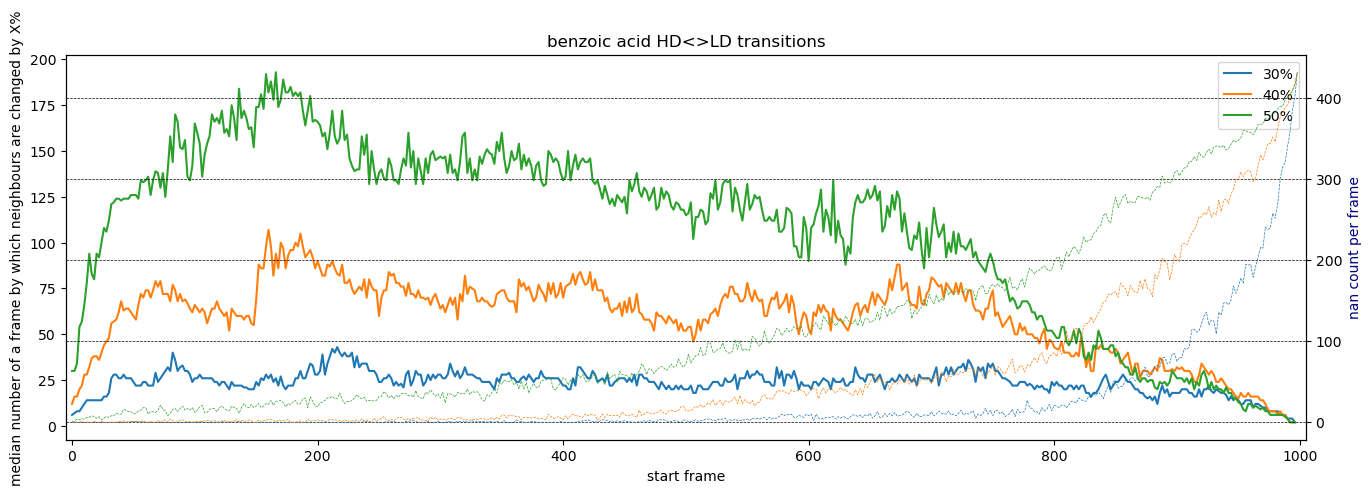

In [153]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.3, 0.4, 0.5), title='benzoic acid HD<>LD transitions')

  0%|          | 0/725 [00:00<?, ?it/s]

  0%|          | 0/725 [00:00<?, ?it/s]

  0%|          | 0/725 [00:00<?, ?it/s]

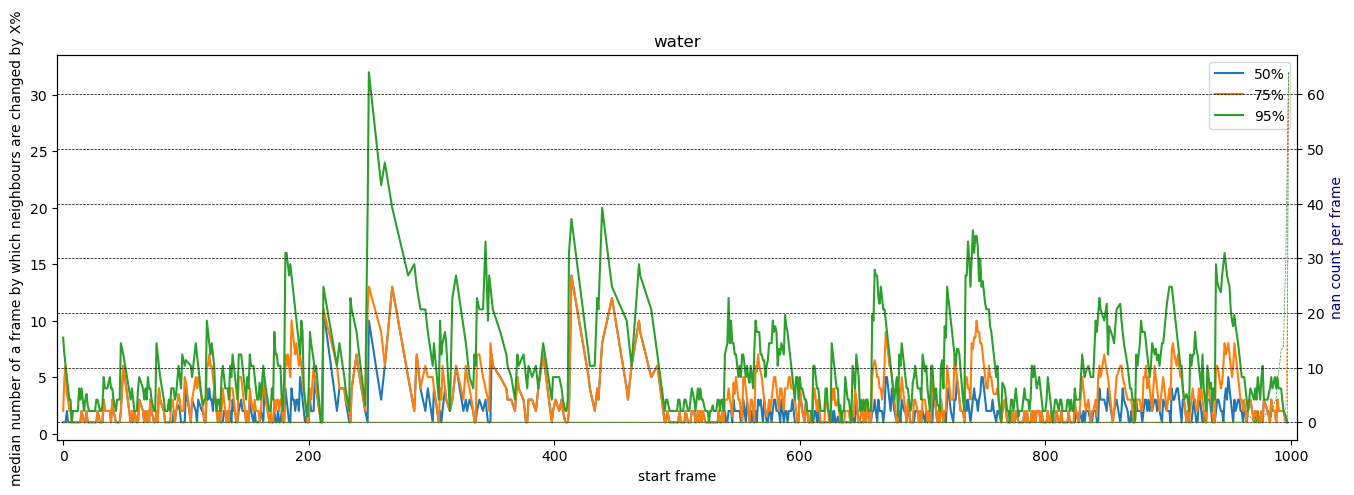

In [31]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.5, 0.75, 0.95), title='water')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

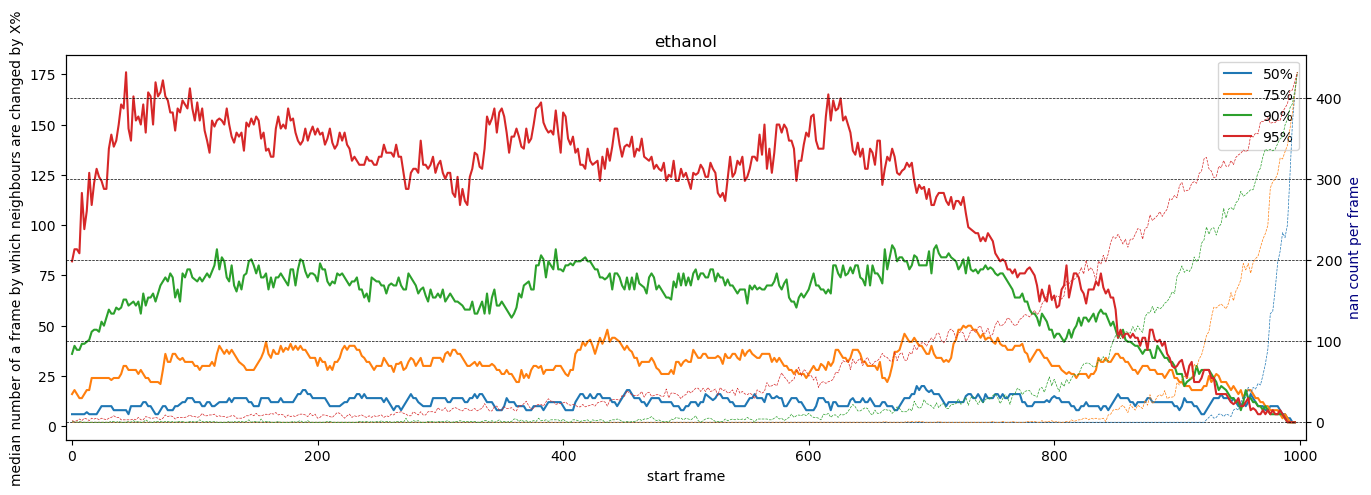

In [38]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.5, 0.75, 0.9, 0.95), title='ethanol')

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

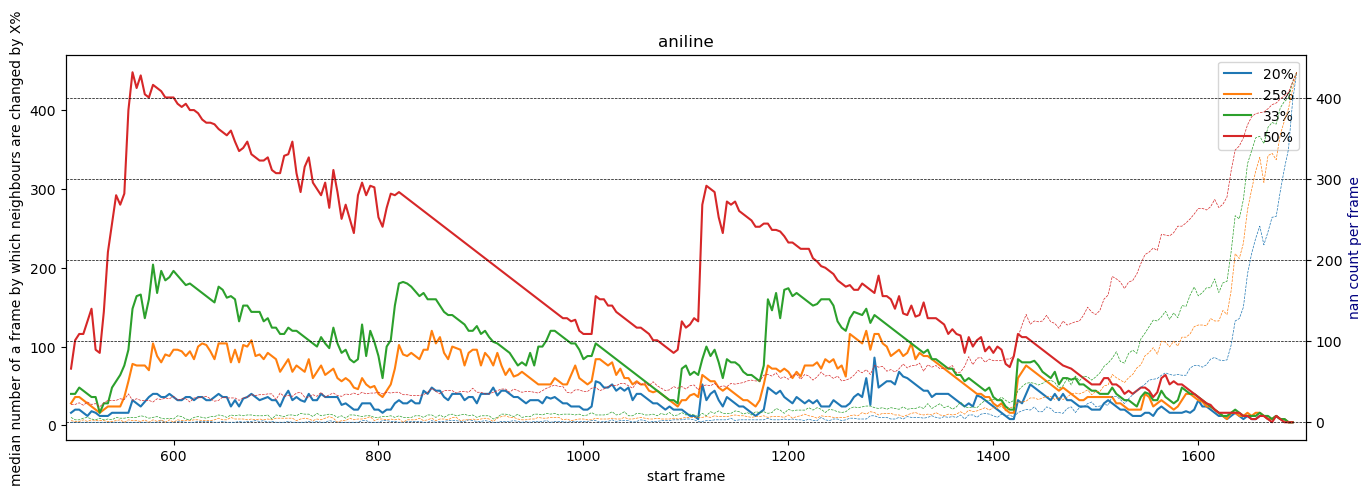

In [57]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(.2, .25, .33, .5), title='aniline')

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

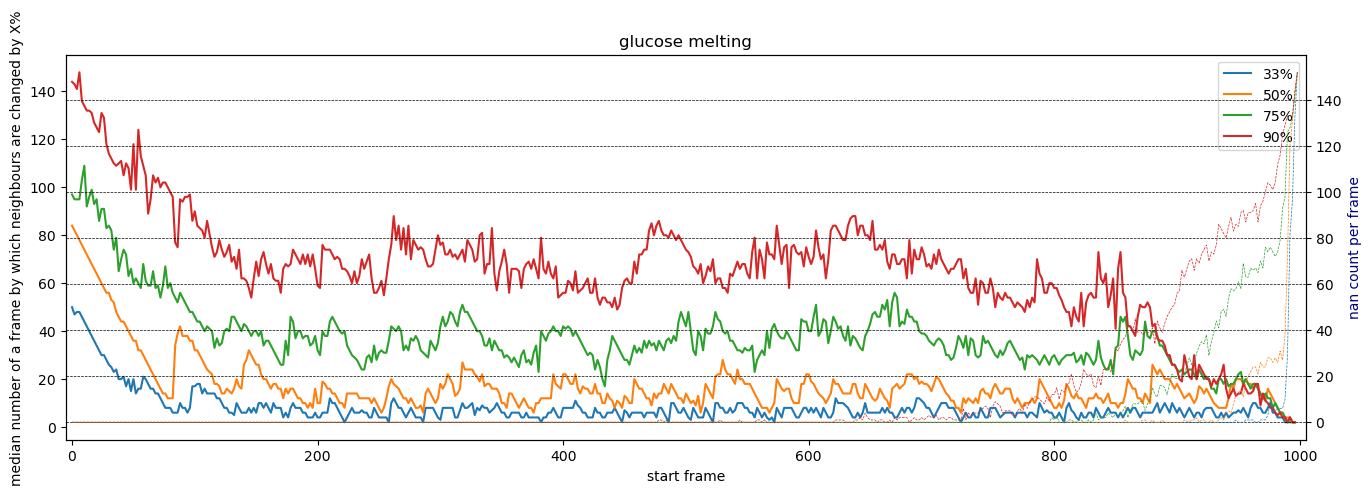

In [23]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.33, 0.5, 0.75, 0.9), title='glucose melting')

In [ ]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(0.25, 0.5, 0.75), title='')

## Analyse neigbour exchange counts

0it [00:00, ?it/s]

0it [00:00, ?it/s]

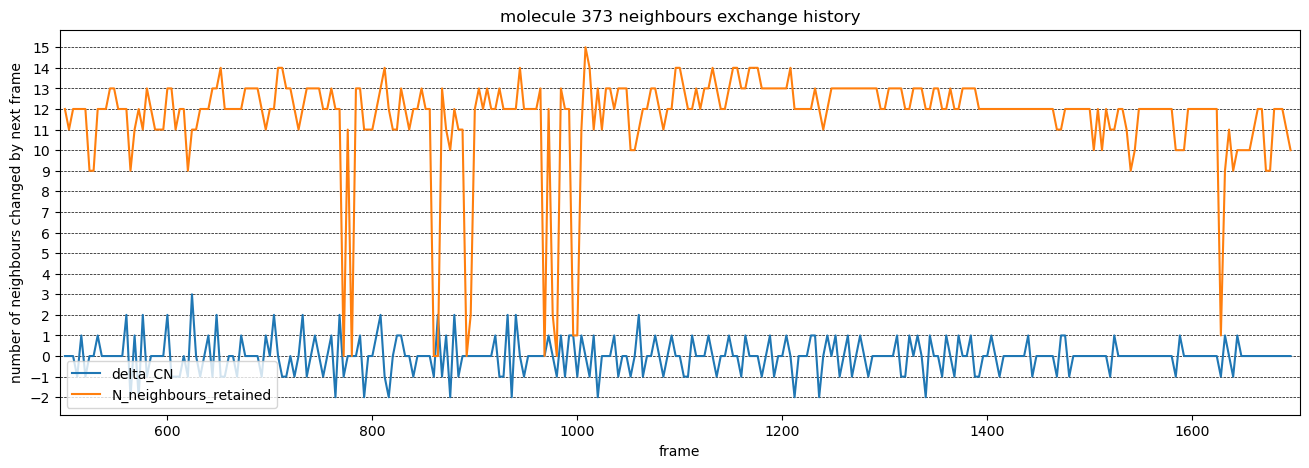

In [143]:
N_molecule = 373 # 373
fig, ax = plt.subplots(figsize=(16, 5))

ax.set_title(f"molecule {N_molecule} neighbours exchange history")

for exchange_type in ('delta_CN', 'N_neighbours_retained'): # 'N_neighbours_in', 'N_neighbours_out', 'delta_CN', 'N_neighbours_retained'
    neighbours_changed_counts = calculate_neighbour_exchange_count(df_dict, exchange_type=exchange_type)
    df_neighbours_changed_counts = pd.DataFrame(neighbours_changed_counts)
    df_neighbours_changed_counts.loc[[N_molecule], :].T.rename(columns={N_molecule: f'{exchange_type}'}).plot(ax=ax)

ax.legend(loc='lower left')
ax.set_xlabel('frame')
ax.set_xlim(min(df_dict.keys()) - 5, max(df_dict.keys()) + 5)
ax.set_ylabel('number of neighbours changed by next frame')
range_min_y, range_max_y = ax.get_ylim()
_ = ax.set_yticks(range(int(range_min_y), int(range_max_y)+1))
plt.grid(visible=True, axis='y', color='k', linestyle='--', linewidth=.5)

In [59]:
neighbours_changed_counts = calculate_neighbour_exchange_count(df_dict, exchange_type='N_neighbours_retained')
df_neighbours_changed_counts = pd.DataFrame(neighbours_changed_counts)

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

<AxesSubplot:ylabel='nan count per frame'>

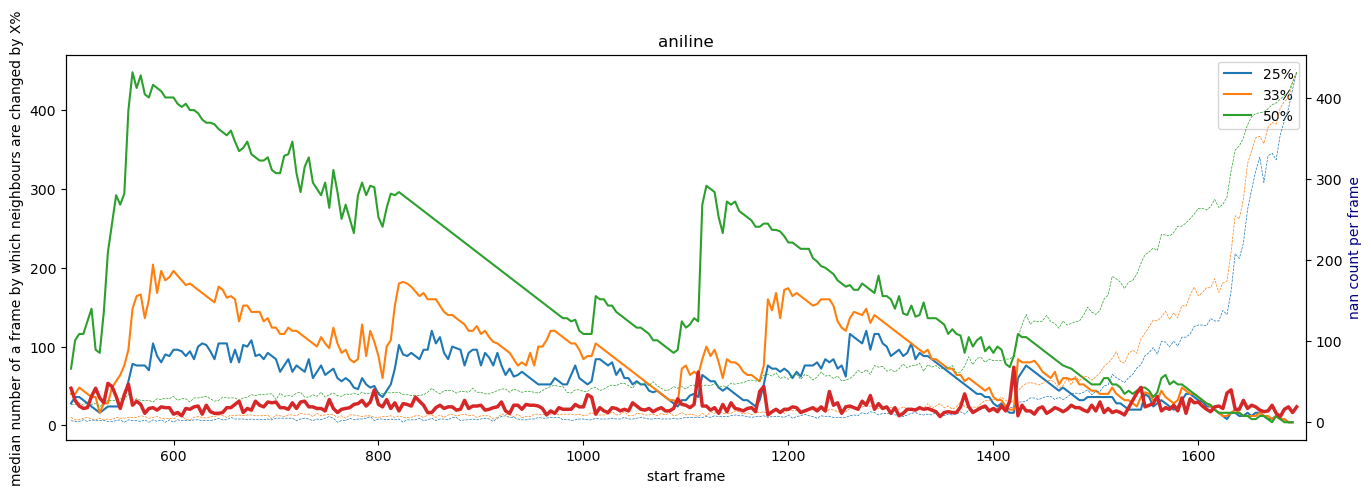

In [142]:
plot_neighbour_exchange_times(df_dict, exchange_shares=(.25, .33, .5), title='aniline')
df_neighbours_changed_counts.le(6).sum(axis=0).plot(label=6, lw=2.5)

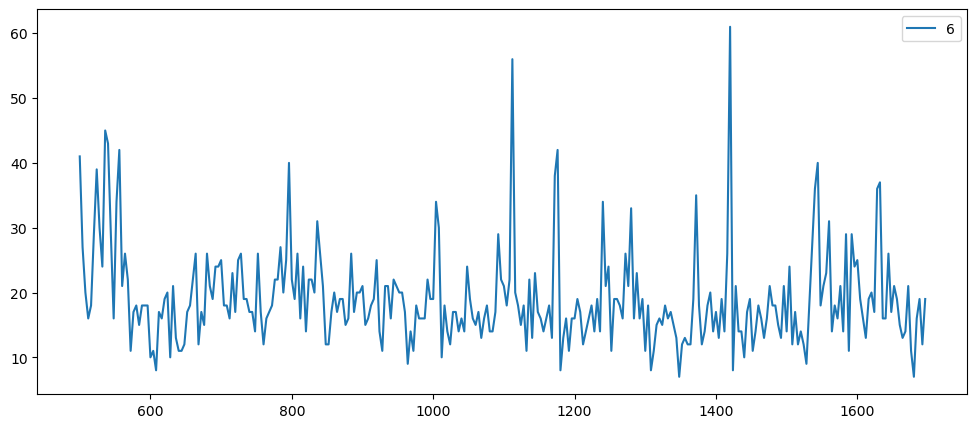

In [118]:
plt.figure(figsize=(12, 5))

for n in (6, ):#range(3, 10):
    df_neighbours_changed_counts.le(5).sum(axis=0).plot(label=n) # number of molecules per frame for which less than n neighbours are left in the next frame
plt.legend()

In [93]:
pd.Series(df_neighbours_changed_counts.values.flatten()).value_counts()

12    37676
11    31191
13    22125
10    16002
14     7525
9      5814
0      3106
8      1722
1      1665
15     1226
2       577
7       417
3       226
4        98
16       96
6        84
5        45
17        5
Name: count, dtype: int64

In [139]:
res = np.zeros((15, 15))

for i, n in enumerate(range(0, 15)):
    for j, m in enumerate(range(0, 15)):
        n_series = df_neighbours_changed_counts.le(n).sum(axis=0)
        m_series = df_neighbours_changed_counts.le(m).sum(axis=0)
        res[i, j] = np.log2(np.linalg.norm(n_series - m_series) + 1)

<AxesSubplot:>

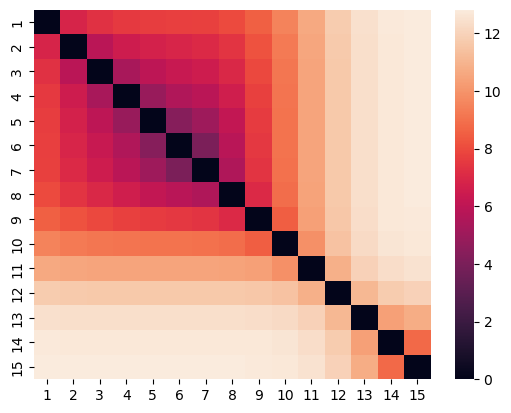

In [140]:
sns.heatmap(res, xticklabels=[str(i) for i in range(1, 16)], yticklabels=[str(i) for i in range(1, 16)])

<AxesSubplot:>

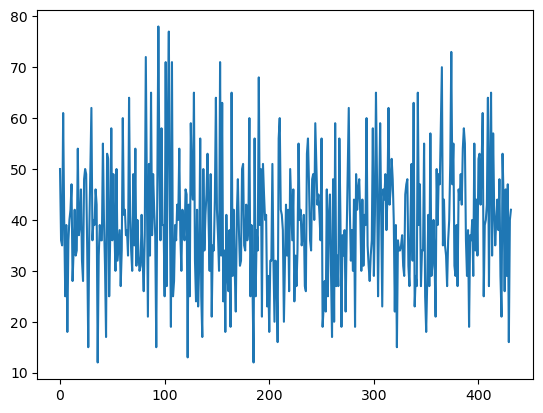

In [47]:
df_neighbours_changed_counts.le(3).sum(axis=1).plot() # number of cage-leave events for molecule

## Reading pdb with connectivity

In [32]:
system = 'pntnmdc'

In [33]:
with open(f'{system}_connectivity.cif', 'r') as inp:
    content = inp.readlines()

In [34]:
for i, line in enumerate(content):
    if line.startswith('_topol_link.multiplicity'):
        connectivity_data_start_line = i + 1

In [35]:
connectivity_lines = [l.strip() for l in content[connectivity_data_start_line:-1] if ' v ' in l]

In [36]:
vconnectivity = []

for l in connectivity_lines:
    i, j, *_ = l.split()
    # print(i, j, t1, t2, t3, btype)
    i = int(i) - 1
    j = int(j) - 1
    vconnectivity.append((i, j))

In [37]:
len(vconnectivity)

6912

In [38]:
vconnectivity = set(vconnectivity)

In [39]:
with open(f'{system}.vconnectivity', 'wb') as out:
    pickle.dump(vconnectivity, out)

In [27]:
df = pd.read_csv('pntnmdc.csv', sep='\t')

<AxesSubplot:>

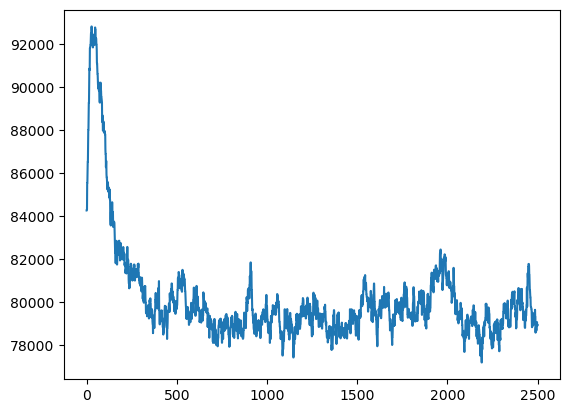

In [28]:
df['V_cell'].plot()

<AxesSubplot:>

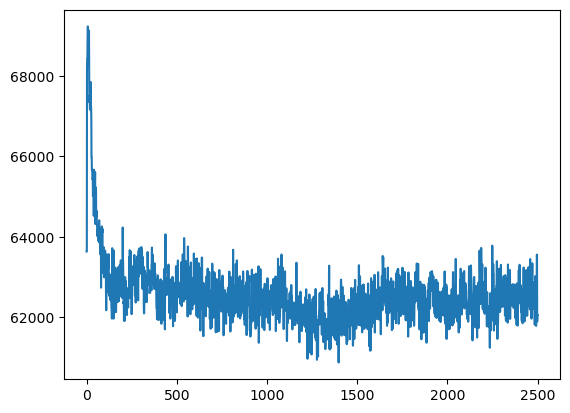

In [251]:
df['V_cell'].plot()